In [14]:
import os
import glob
import time
import sys
import itertools
import json
import pandas as pd
import numpy as np
import librosa as lr
import librosa.display as lrd
import numpy as np
import os.path as osp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import IPython.display as ipd

from sklearn.metrics import mean_squared_error

%matplotlib inline
%precision 2

sys.path.append("..")
from libs.utilities import load_autoencoder_lossfunc, load_autoencoder_model, get_func_name
from libs.processing import pink_noise, take_file_as_noise, \
    make_fragments, unmake_fragments, unmake_fragments_slice, \
    s_to_exp, exp_to_s, s_to_reim, reim_to_s, s_to_db, db_to_s , \
    normalize_spectrum, normalize_spectrum_clean, unnormalize_spectrum 


In [15]:
all_rwnoise_types = {
    'seen': ['NFIELD', 'DKITCHEN'],
    'unseen': [ 'TCAR', 'PSTATION'],
}

# position of all result data! 
all_results_paths = { 
    'ds1': {
        'mag': {
            'rnn': '/home/rmicci18/results/ds1_model_190516_1654_conv_rnn_fb13dc_s_to_exp(1.000)',
            'gru': '/home/rmicci18/results/ds1_model_190516_1506_conv_gru_65c809_s_to_exp(1.000)',
            'tcn': '/home/rmicci18/results/ds1_model_190517_1742_conv_tcn_182082_s_to_exp(1.000)',
            'ae':  None,    
        },
        'db': {
            'rnn': '/home/rmicci18/results/ds1_model_190516_2012_conv_rnn_ce7efe_s_to_db',
            'gru': '/home/rmicci18/results/ds1_model_190516_1111_conv_gru_e39df2_s_to_db',
            'tcn': '/home/rmicci18/results/ds1_model_190517_1547_conv_tcn_a30f3a_s_to_db',
            'ae':  None,    
        }
    },
    'ds2': {
        'mag': {
            'rnn': '/home/rmicci18/results/ds2_model_190519_1941_conv_rnn_fb13dc_s_to_exp(1.000)',
            'gru': '/home/rmicci18/results/ds2_model_190519_1942_conv_gru_65c809_s_to_exp(1.000)',
            'tcn': '/home/rmicci18/results/ds2_model_190521_1016_conv_tcn_182082_s_to_exp(1.000)',
            'ae':  '/home/rmicci18/results/ds2_model_190523_1051_conv_ae_dbf00a_s_to_exp(1.000)',    
        },
        'db': {
            'rnn': '/home/rmicci18/results/ds2_model_190519_1927_conv_rnn_fb13dc_s_to_db',
            'gru': '/home/rmicci18/results/ds2_model_190520_0956_conv_gru_e39df2_s_to_db',
            'tcn': '/home/rmicci18/results/ds2_model_190520_1846_conv_tcn_507322_s_to_db',
            'ae':  '/home/rmicci18/results/ds2_model_190521_1547_conv_ae_a4bc31_s_to_db'  
        }
    },
}

In [16]:
# collect and treat data from DS1 trainings (pink noise)
def load_data_ds1(results_paths):
    data5 = {}
    data15 = {}
    for model_name, result_path in results_paths.items():
        if not result_path:
            continue
        fullname = title="conv-{}".format(model_name)
        
        real_result_path = glob.glob(osp.join(result_path, '*.pkl'))
        if not real_result_path:
            continue
        
        real_result_path = real_result_path[0]
        
        df = pd.read_pickle(real_result_path)
        df = df.groupby('noise_variation').mean()                
        df = df.rename(index={"('pink_noise', 15)": '15', 
                              "('pink_noise', 5)": '5'})
        
        data5 = {**data5, **pd.DataFrame({fullname : df.T['5'].T}).to_dict()}
        data15 = {**data15, **pd.DataFrame({fullname : df.T['15'].T}).to_dict()}
    
    return {
        ('pink', 5): pd.DataFrame(data5), 
        ('pink', 15): pd.DataFrame(data15)
    }


In [17]:
# collect and treat data from DS2 trainings (rw noise)
def load_data_ds2(results_paths):
    data5 = {}
    data15 = {}
    data5test = {}
    data15test = {}
    for model_name, result_path in results_paths.items():
        if not result_path:
            continue
        fullname = title="conv-{}".format(model_name)
        
        real_result_path = glob.glob(osp.join(result_path, '*.pkl'))
        if not real_result_path:
            continue
        
        real_result_path = real_result_path[0]
        
        df = pd.read_pickle(real_result_path)
        df = df.groupby('noise_variation').mean()
        
        # rename dicts
        re_seen5 =  {oldindex: 'seen, 5'  for oldindex in df.index if ', 5'  in oldindex and any(x in oldindex for x in all_rwnoise_types['seen'])}
        re_seen15 = {oldindex: 'seen, 15' for oldindex in df.index if ', 15' in oldindex and any(x in oldindex for x in all_rwnoise_types['seen'])}
        re_unseen5 =  {oldindex: 'unseen, 5'  for oldindex in df.index if ', 5'  in oldindex and any(x in oldindex for x in all_rwnoise_types['unseen'])}
        re_unseen15 = {oldindex: 'unseen, 15' for oldindex in df.index if ', 15' in oldindex and any(x in oldindex for x in all_rwnoise_types['unseen'])}
                
        df = df.rename(index={**re_seen5, 
                              **re_seen15, 
                              **re_unseen5,  
                              **re_unseen15})
    
        df = df.groupby('noise_variation').mean()
                              
        
        data5 = {**data5, **pd.DataFrame({fullname : df.T['seen, 5'].T}).to_dict()}
        data15 = {**data15, **pd.DataFrame({fullname : df.T['seen, 15'].T}).to_dict()}
        data5test = {**data5, **pd.DataFrame({fullname : df.T['unseen, 5'].T}).to_dict()}
        data15test = {**data15, **pd.DataFrame({fullname : df.T['unseen, 15'].T}).to_dict()}
    
    return {
        ('seen', 5): pd.DataFrame(data5), 
        ('seen', 15): pd.DataFrame(data15), 
        ('unseen', 5): pd.DataFrame(data5test), 
        ('unseen', 15): pd.DataFrame(data15test)
    }


In [20]:
# plot a dataframe (metrics for all models vs SNR/data_repr combination)
def plot_data(df, title=None):
    data = df.T

    data_columns = ['mse', 'sar', 'sir', 'sdr', 'stoi', 'pesq']
    data_scale_y = [None,  25,    35,    25,    1,      4.5]

    colormap = cm.rainbow
    model_colors = [colors.rgb2hex(colormap(i / 4)) for i in range(4)]

    fig, axs = plt.subplots(1,6, figsize=(16,4), dpi=250)
    if title:
        plt.suptitle(title)

    #axs = df5.T.plot.bar(figsize=(16,8), subplots=True, layout=(1,6), rot=45, legend=None, color=model_colors, width=1.0)
    for col, ax, ylim in zip(data_columns, axs, data_scale_y):
        data[col].plot.bar(ax=ax, rot=45, legend=None, color=model_colors, width=1, title=col.upper())
        ax.spines['top'].set_color('none')    
        ax.spines['right'].set_color('none')
        ax.set_ylim((0, ylim))
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    #plt.subplots_adjust(wspace=0, hspace=0)
    
    
    
    

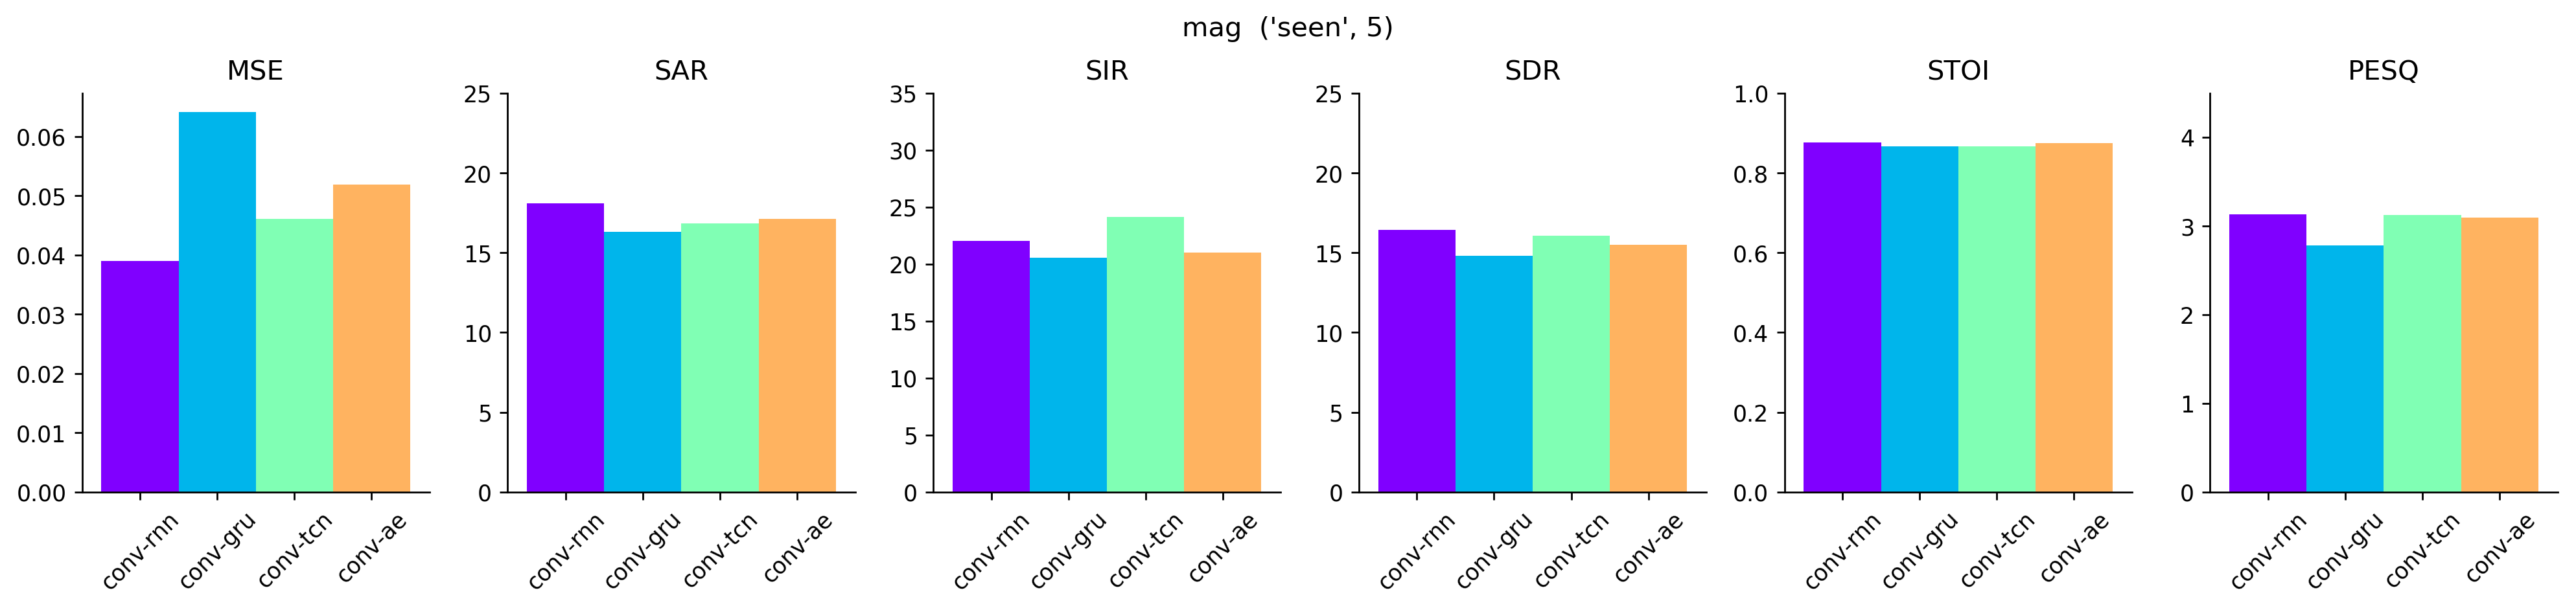

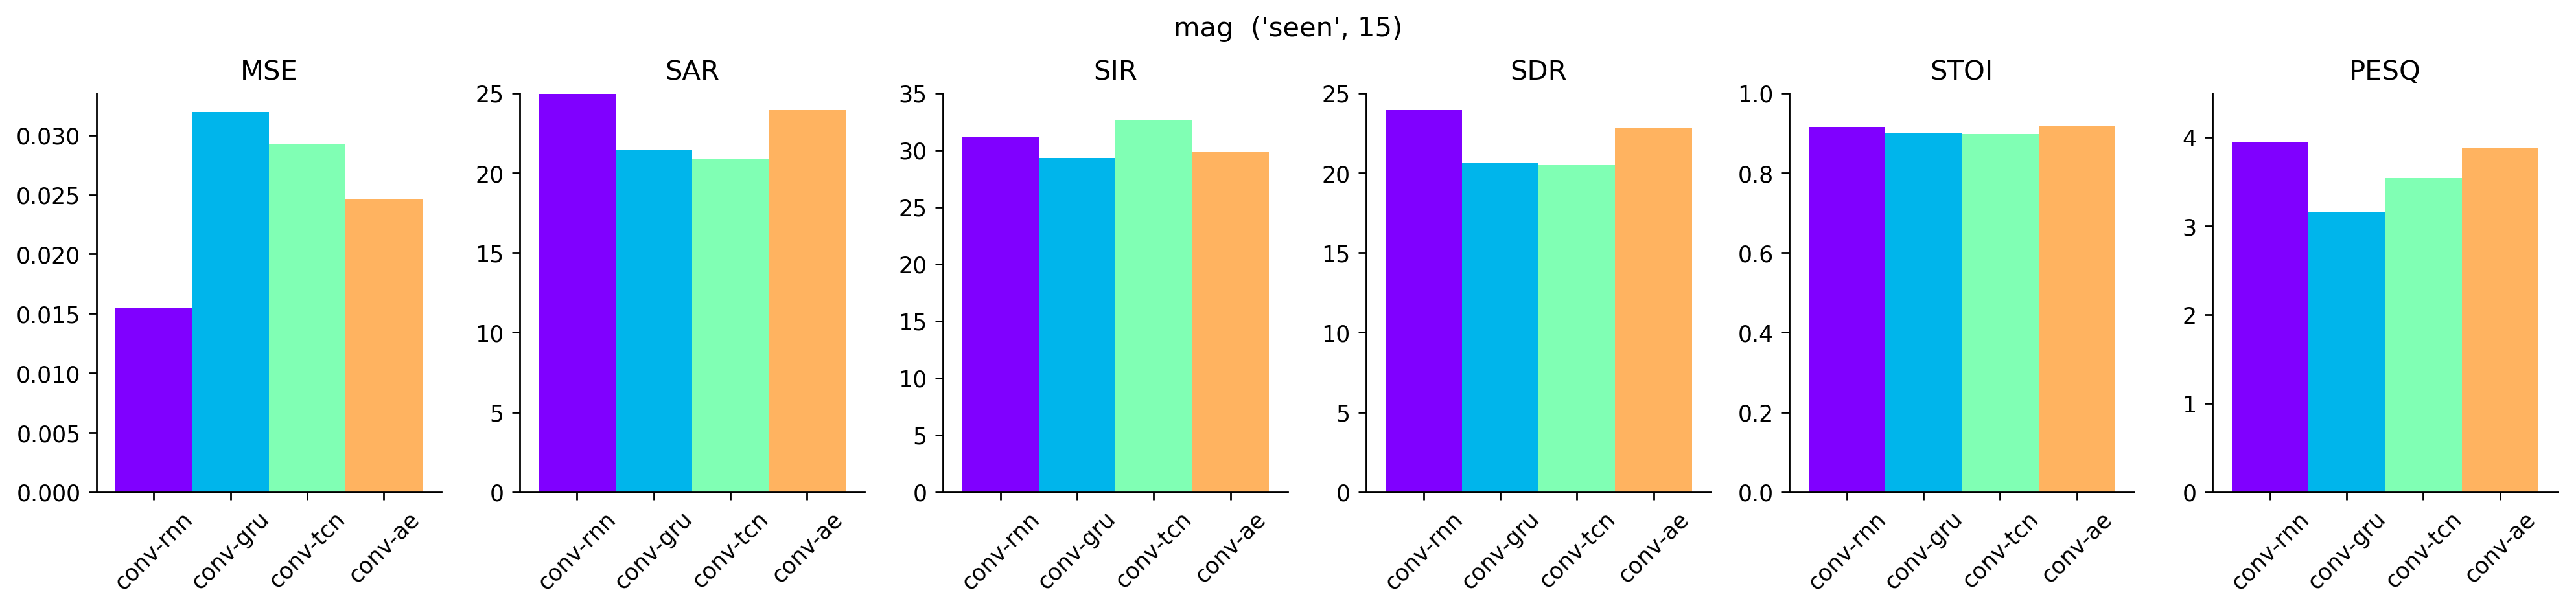

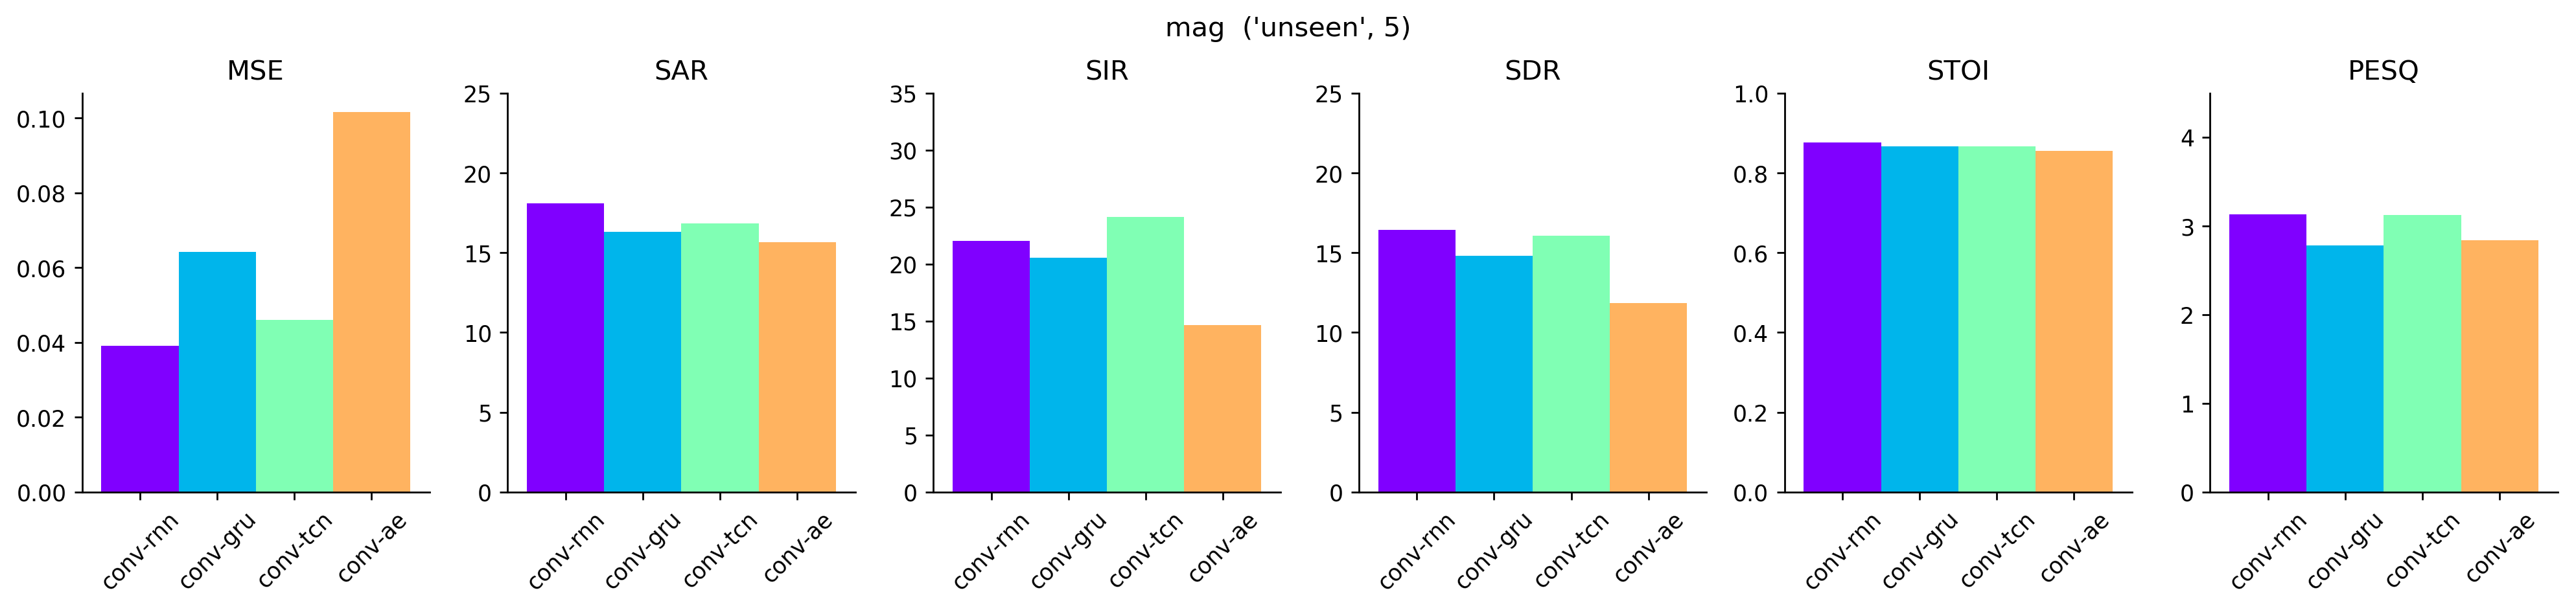

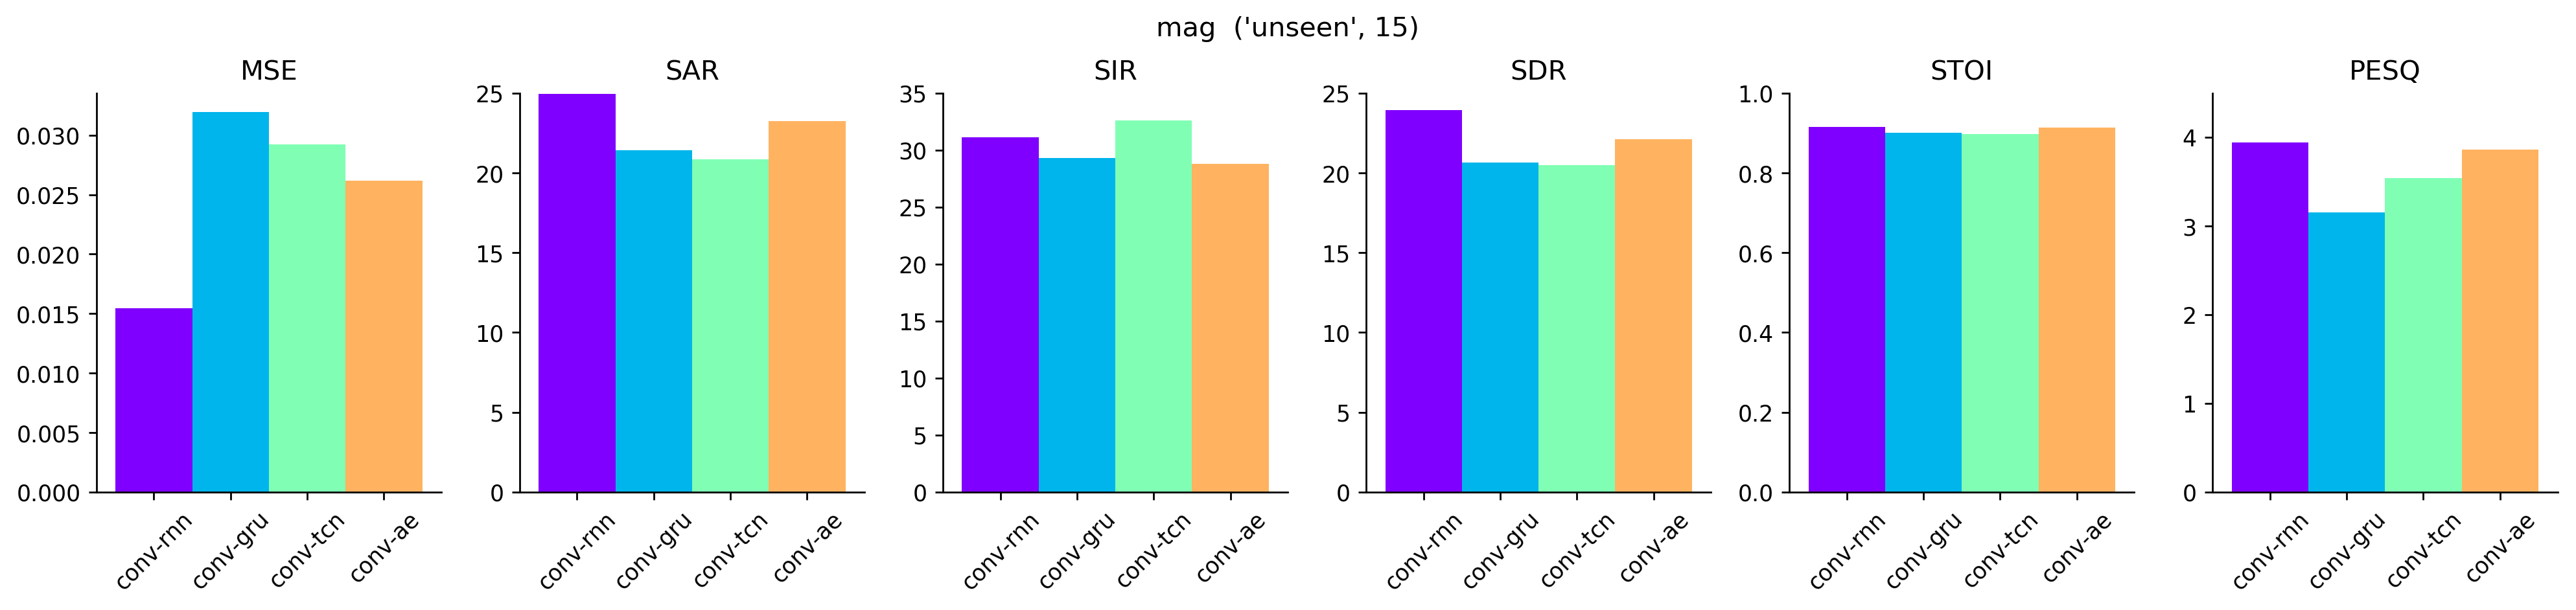

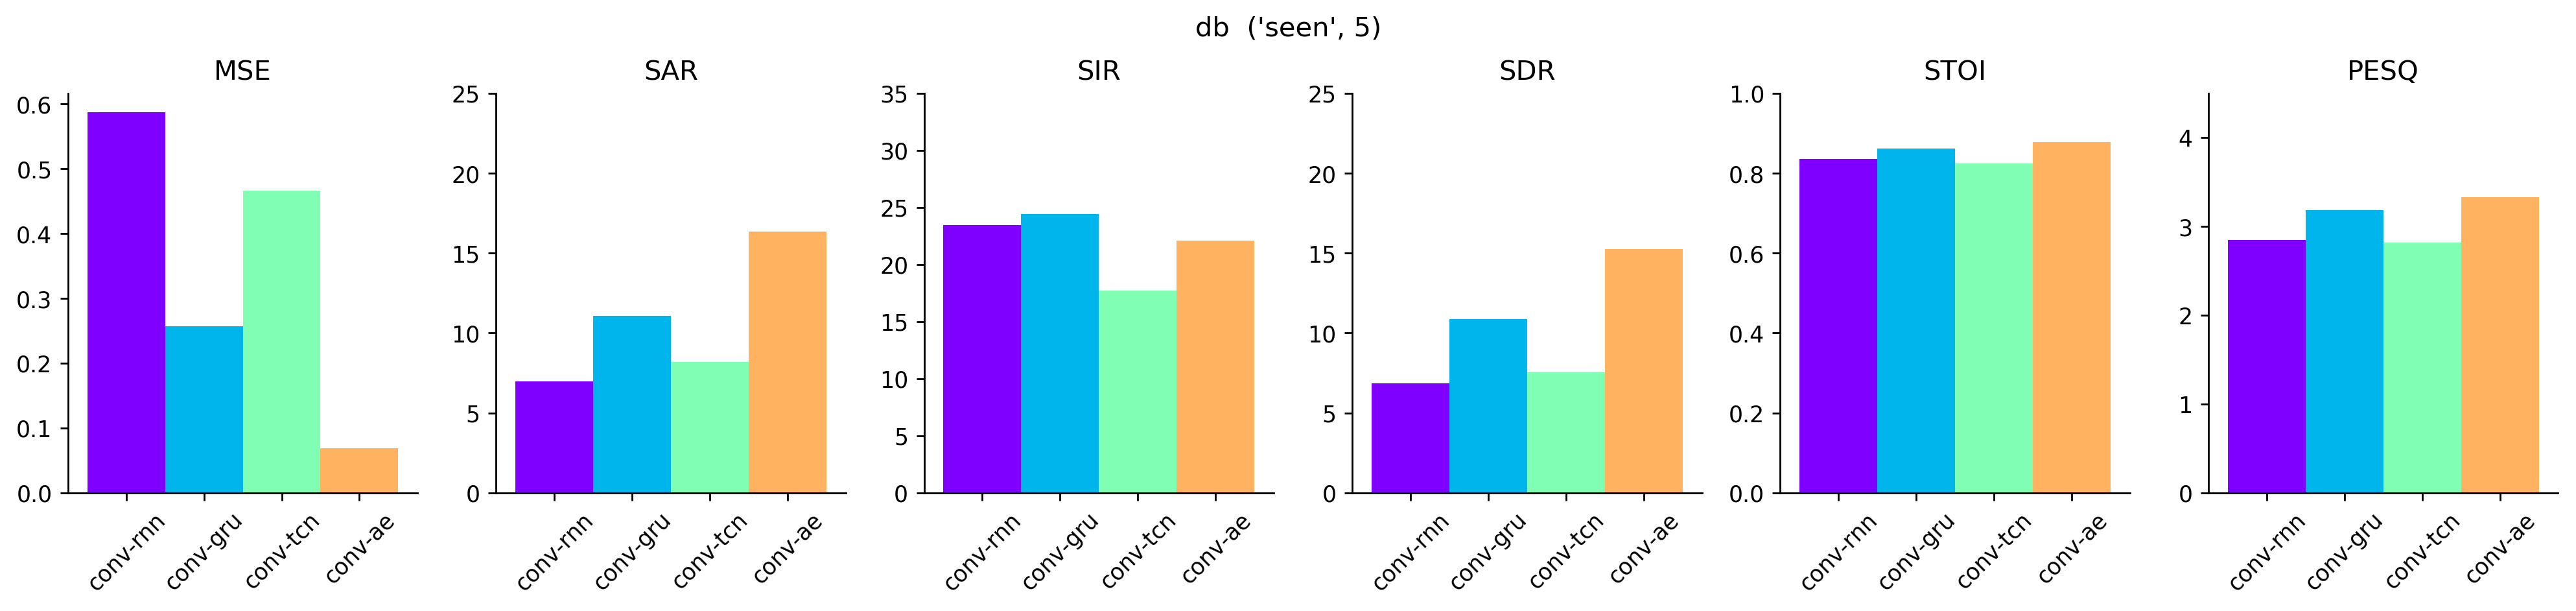

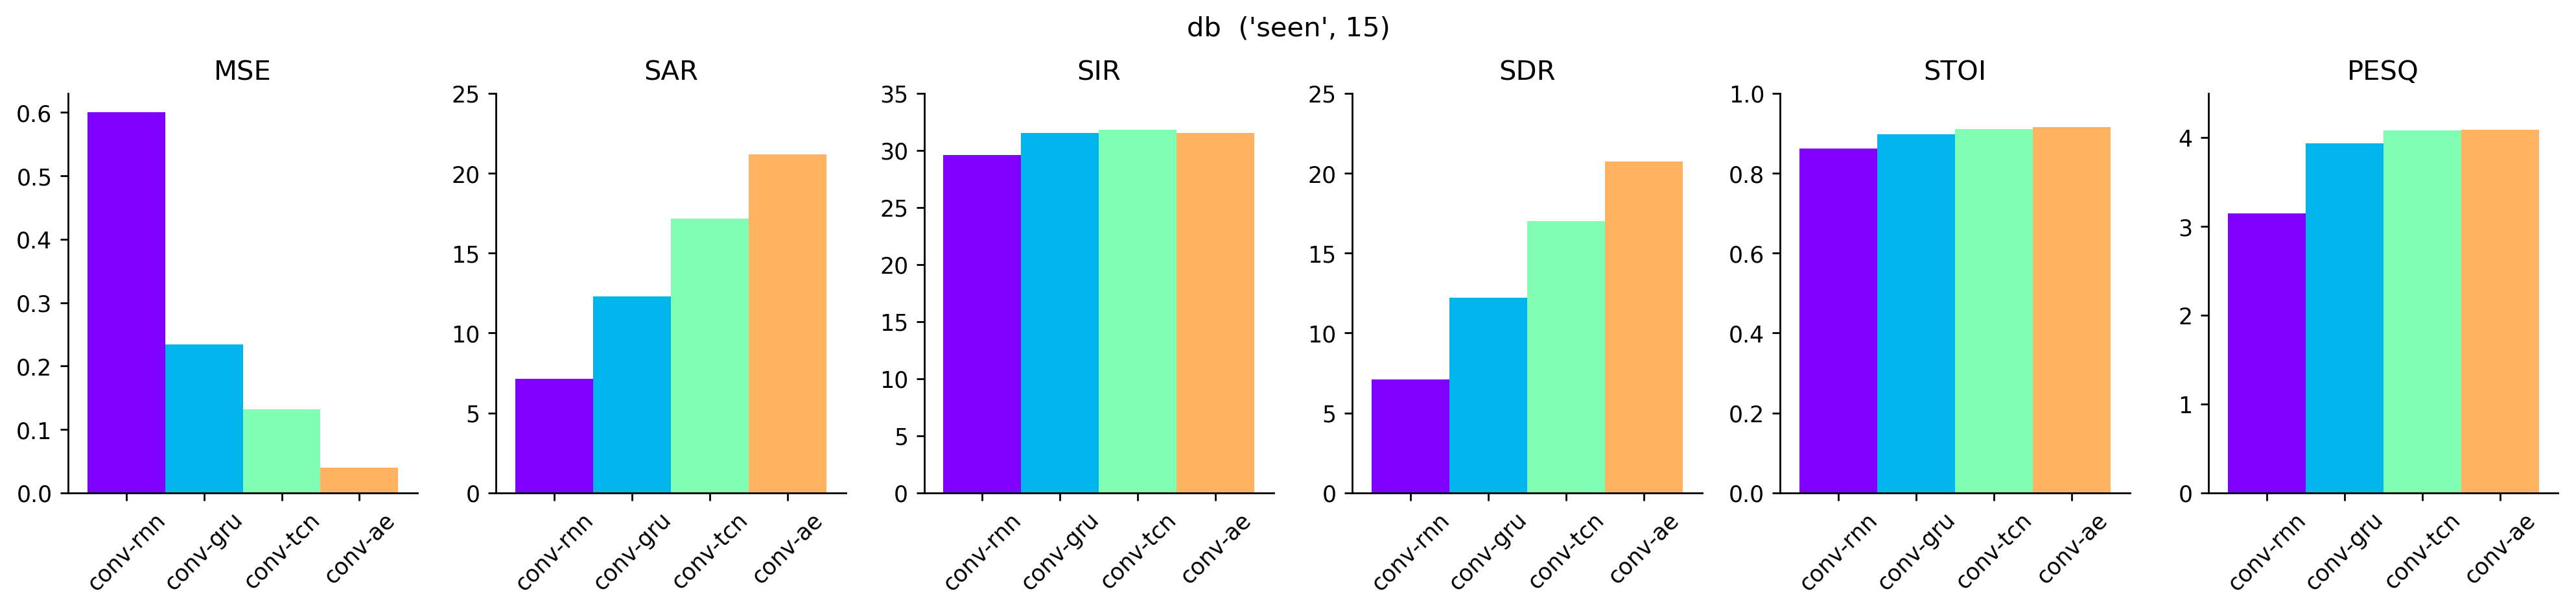

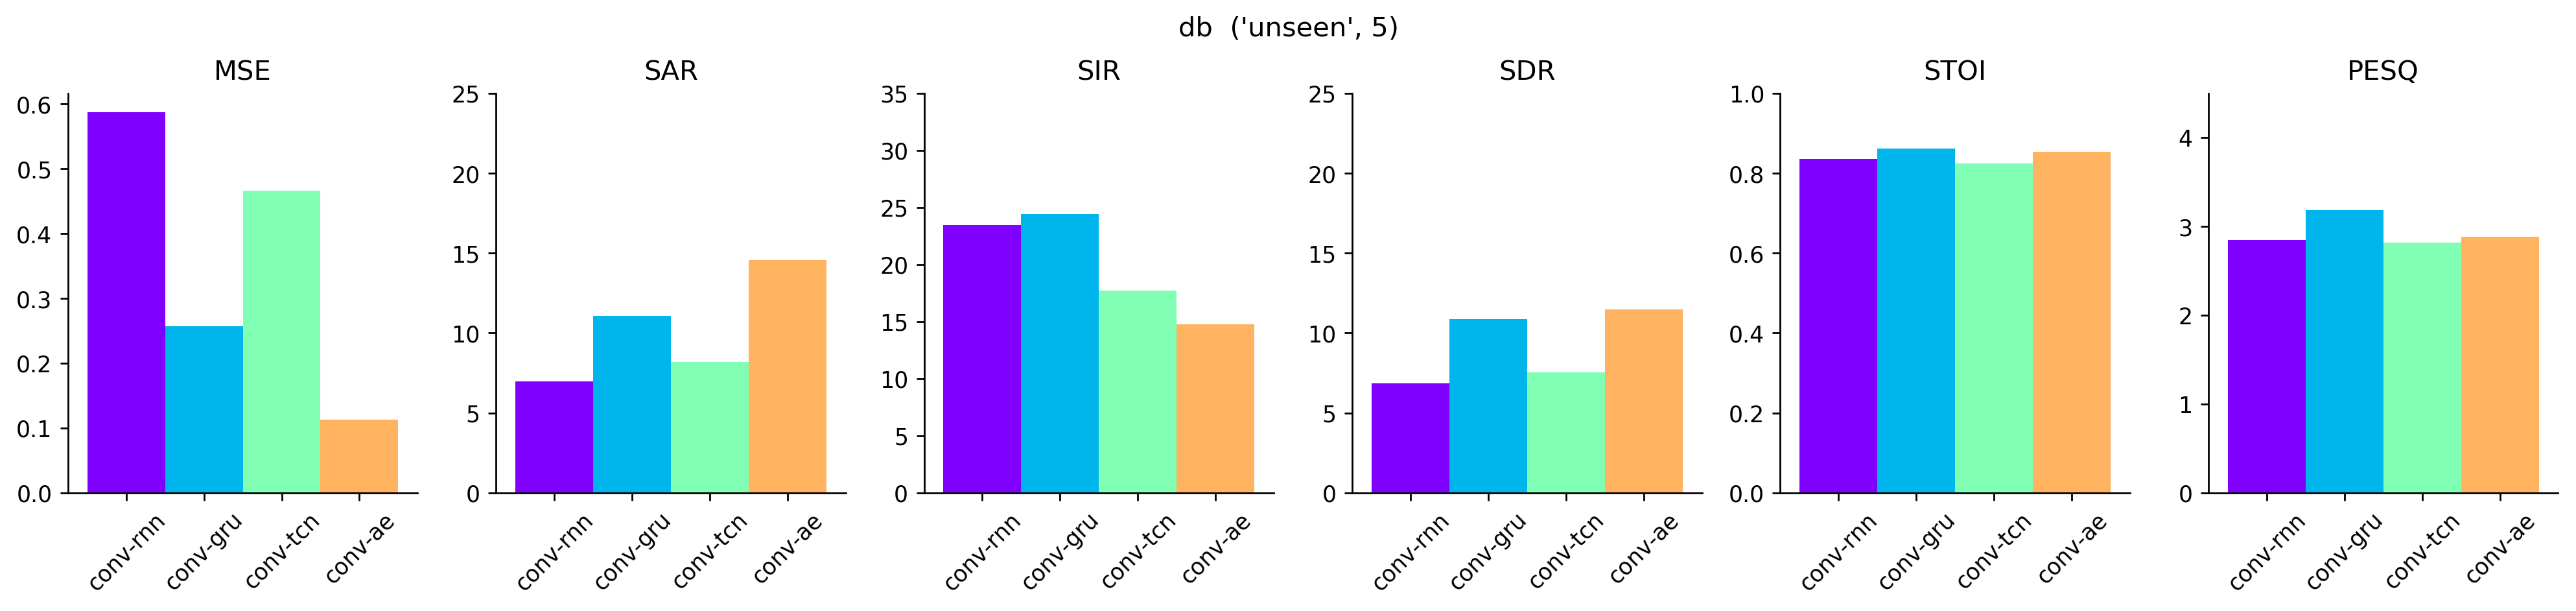

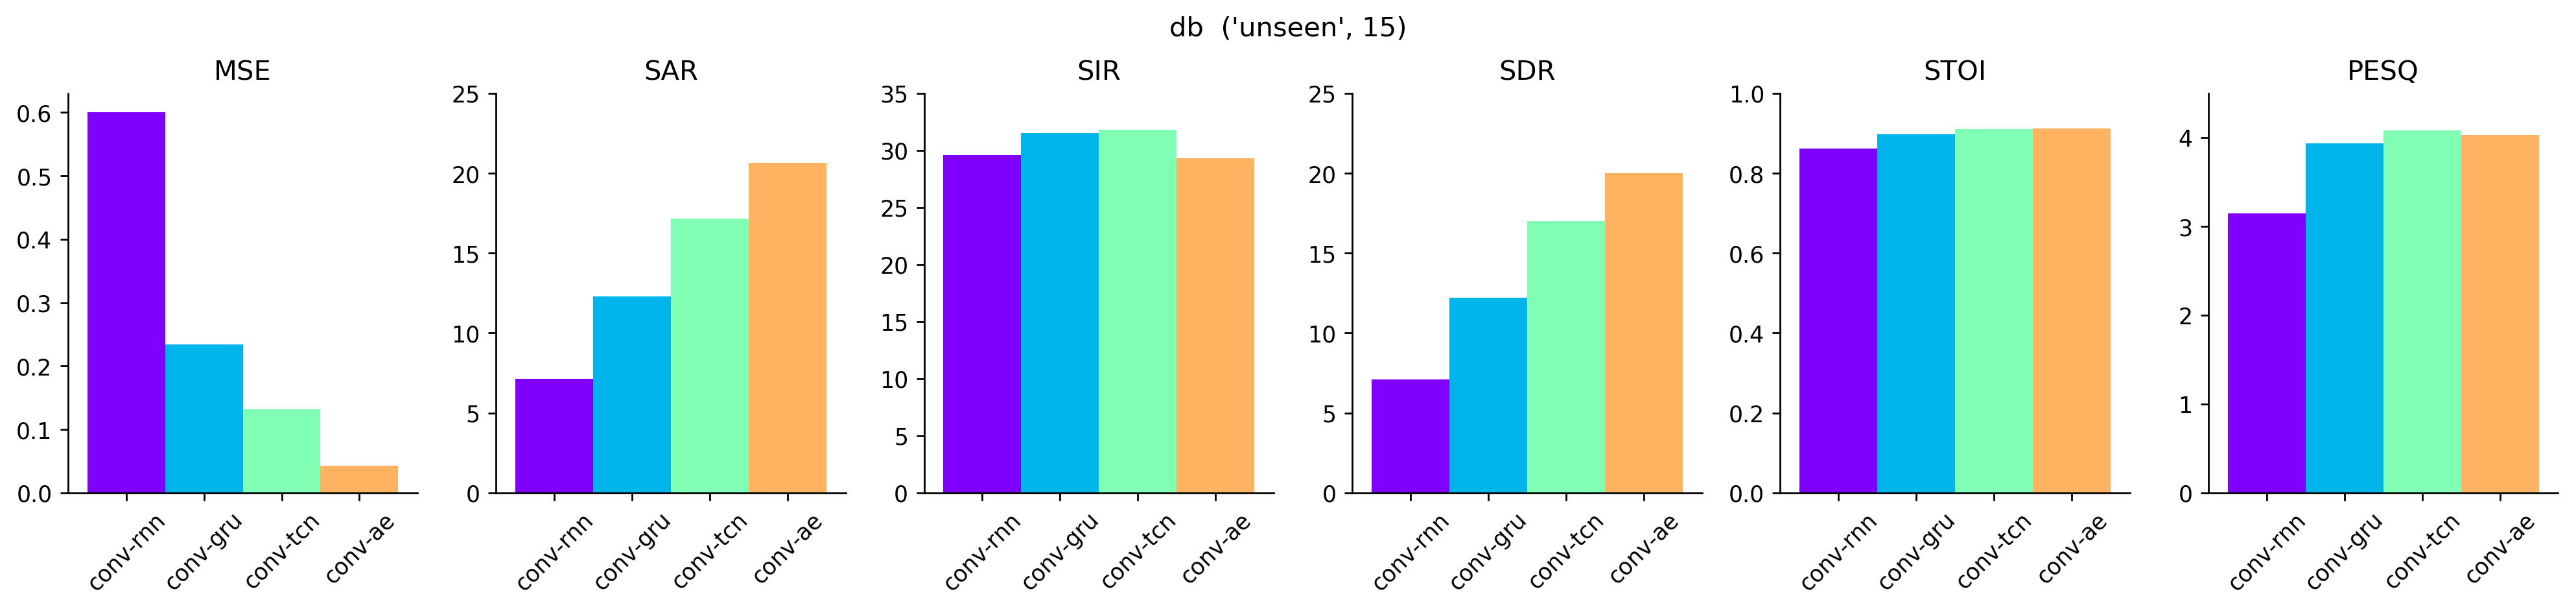

In [21]:
# plot all the plottable stuff!
for repr_name in all_results_paths['ds2']:
    dfs = load_data_ds2(all_results_paths['ds2'][repr_name])
    for df_i in dfs:
        plot_data(dfs[df_i], '{}  {}'.format(repr_name, df_i))

In [636]:
# resulting datasets can also be pivoted, printed, and exported to latex!
# example:
print(df5.round(2))
print()
print()
print(df5.T.round(2).to_latex())

      conv-rnn  conv-gru  conv-tcn
mse       0.69      0.59      0.31
pesq      2.21      2.30      3.06
sar       5.98      6.91     11.10
sdr       5.52      6.57     10.60
sir      16.51     18.72     20.65
stoi      0.82      0.82      0.83


\begin{tabular}{lrrrrrr}
\toprule
{} &   mse &  pesq &    sar &    sdr &    sir &  stoi \\
\midrule
conv-rnn &  0.69 &  2.21 &   5.98 &   5.52 &  16.51 &  0.82 \\
conv-gru &  0.59 &  2.30 &   6.91 &   6.57 &  18.72 &  0.82 \\
conv-tcn &  0.31 &  3.06 &  11.10 &  10.60 &  20.65 &  0.83 \\
\bottomrule
\end{tabular}



In [641]:
# list of all audio samples in results
sample_paths = glob.glob('/home/rmicci18/results/**/**/**/*.wav')
# function for extracting a specific sample
def get_samples(model, data_repr, snr, noise, cast, sample_type):
    sample_path, sample, sr = None, None, None
    results_dirs = ''.join([
        all_results_paths['ds1'][data_repr][model],
        all_results_paths['ds2'][data_repr][model]
    ])
    for p in sample_paths:
        results_dir = osp.basename(osp.dirname(osp.dirname(osp.dirname(p))))
        
        if (('conv_{}'.format(model) in p) 
           and ('snr_{}'.format(snr) in p) 
           and (noise in p) 
           and (cast in p) 
           and (sample_type in p)
           and (results_dir in results_dirs)):
            print('found!')
            x, sr = lr.load(p, duration=30)
            sample = x
            sample_path = p
    return sample_path, sample, sr

In [642]:
# list of all casts for each dataset:
print('DS1:')
for p in glob.glob('/data/riccardo_datasets/npr_news/ds1/test/*.wav'):
    print(osp.basename(p))

print()
print('DS2:')
for p in glob.glob('/data/riccardo_datasets/npr_news/ds2/test/*.wav'):
    print(osp.basename(p))

DS1:
newscast230822.wav
newscast220831.wav
newscast230857.wav
newscast230833.wav

DS2:
NPR_News__03-16-2018_11PM_ET.wav
NPR_News__03-15-2018_11PM_ET.wav
NPR_News__03-18-2018_11PM_ET.wav
NPR_News__03-14-2018_10PM_ET.wav


In [646]:
# example usage:
sample_path, sample, sr = get_samples('tcn', 'db', 5, 'TCAR', 'NPR_News__03-16-2018_11PM_ET', 'pred')
print(osp.basename(sample_path))
ipd.Audio(sample, rate=sr)

found!
NPR_News__03-16-2018_11PM_ET_take_file_as_noise(TCAR, 11.770461)_x_pred.wav


In [ ]:
i 256
1 64
2 8
3 1

In [24]:
np.log2(256 / 2)

7.0

In [28]:
(256 / 4)**(1/3)

4.00